# Ambiguity and Error calculation


This section analyzes the ambiguity between classes by measuring the overlap in their probability distributions. A high degree of overlap indicates that the classes are difficult to distinguish, contributing to classification uncertainty.

Additionally, it evaluates the classification error by examining the probability that a segmented region of a sample from one class is misclassified as belonging to another class. This provides insights into both the model's uncertainty and potential sources of misclassification.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Cross-validation accuracy calculation for classical ML classification algorithms

In [2]:
def generate_synthetic_dataset(num_samples):
    """ Takes num of samples and return the df with one features and two class """
    np.random.seed(0)
    samples = int(num_samples /2)
    label_0 = np.zeros(samples)
    label_1 = np.ones(samples)

    mu_1 = 12
    sigma_1 = 5
    class_1_data = np.random.normal(mu_1, sigma_1, samples)
    mu_0 = 0
    sigma_0 = 4
    class_0_data = np.random.normal(mu_0, sigma_0, samples)
    data  =  np.concatenate((class_0_data, class_1_data)) 
    labels = np.concatenate((label_0, label_1))

    d = {
        "feature": data,
        "Label": labels
    }
    df = pd.DataFrame(data =d)
    return df



In [3]:
def data_visualization(df):
    class_0_data = df[df['Label'] == 0]['feature']
    class_1_data = df[df['Label'] == 1]['feature']

    plt.figure()
    sns.kdeplot(class_0_data, color='blue', label='Class 0')
    sns.kdeplot(class_1_data, color='red', label='Class 1')

    plt.scatter(class_0_data, np.zeros_like(class_0_data), color='blue', alpha=0.6, label='Class 0 Samples')
    plt.scatter(class_1_data, np.zeros_like(class_1_data), color='red', alpha=0.6, label='Class 1 Samples')

    plt.title('Class Conditional Density Plot of Feature')
    plt.ylim(-0.05, .15)
    plt.xlabel('Feature')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
def select_model(model):
    if model == "logistic_regression" :
        return LogisticRegression() 
    elif model == "naive_bayes":
        return GaussianNB()
    elif model == "random_forest":
        return RandomForestClassifier(max_depth=2, random_state=0)
    else:
        raise ValueError("Unknown model type: {}".format(model))

In [5]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
df = generate_synthetic_dataset(1000)

X = df[['feature']]
y = df['Label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X, y)
    y_pred = model.predict(X)
    # global performance
    global_accuracy = accuracy_score(y, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")
    


Model name: logistic_regression, global_accuracy: 0.912, Scores for each fold: [0.92  0.915 0.89  0.92  0.91 ], Average_score: 0.9109999999999999
Model name: naive_bayes, global_accuracy: 0.914, Scores for each fold: [0.925 0.925 0.895 0.915 0.905], Average_score: 0.913
Model name: random_forest, global_accuracy: 0.919, Scores for each fold: [0.925 0.935 0.9   0.925 0.9  ], Average_score: 0.9170000000000001


In [6]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

X = df[['feature']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split = 2, min_samples_leaf =1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    # print(left)
    # print(right)
    # print(threshold)

    def recurse(node, bounds):
        if threshold[node] == -2:
            # It's a leaf node
            return bounds
        
        new_bounds_left = []
        new_bounds_right = []
        for left_b, right_b in bounds:
            n_bounds_left = [left_b, threshold[node]]
            n_bounds_right = [threshold[node], right_b]
            new_bounds_left.append(n_bounds_left)
            new_bounds_right.append(n_bounds_right)

        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds: [x1_min, x1_max, x2_min, x2_max]
    initial_bounds = [[-np.inf, np.inf]] * tree.tree_.n_features
    print(initial_bounds)
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Example usage
rectangles = get_rectangles_from_tree(clf)

Training Accuracy: 100.00%
[[-inf, inf]]


# Maximum coverage calculation using Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

X = df[['feature']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split = 2, min_samples_leaf =1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rules from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold

    def recurse(node, bounds):
        if threshold[node] == -2:
            # It's a leaf node
            return bounds
        
        new_bounds_left = []
        new_bounds_right = []
        for left_b, right_b in bounds:
            n_bounds_left = [left_b, threshold[node]]
            n_bounds_right = [threshold[node], right_b]
            new_bounds_left.append(n_bounds_left)
            new_bounds_right.append(n_bounds_right)

        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)

        return left_rectangles + right_rectangles

    # Initial bounds: [x1_min, x1_max, x2_min, x2_max]
    initial_bounds = [[-np.inf, np.inf]] * tree.tree_.n_features
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Example usage
rectangles = get_rectangles_from_tree(clf)

# Calculate KDE for each class
class_0_data = df[df["Label"] == 0]["feature"]
class_1_data = df[df["Label"] == 1]["feature"]

kde_class_0 = stats.gaussian_kde(class_0_data)
kde_class_1 = stats.gaussian_kde(class_1_data)

# Calculate probabilities for the segments
segment_probabilities = []
for start, end in rectangles:
    segment = df[(df['feature'] >= start) & (df['feature'] < end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]   # taking the actual value of the first sample of that segment
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box_1d(start, end))
        else:
            segment_probabilities.append(kde_class_0.integrate_box_1d(start, end))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

Training Accuracy: 100.00%
Total error probability across all segments: 0.2690
Accuracy: 0.7310


In [8]:
rectangles

[[-inf, -1.8715476393699646],
 [-1.8715476393699646, -1.8601572513580322],
 [-1.8601572513580322, -1.69851952791214],
 [-1.69851952791214, -1.6699565052986145],
 [-1.6699565052986145, -1.2992695569992065],
 [-1.2992695569992065, -1.2741339206695557],
 [-1.2741339206695557, -0.7688279449939728],
 [-0.7688279449939728, -0.7469640970230103],
 [-0.7469640970230103, 0.5087456405162811],
 [0.5087456405162811, 0.5753490626811981],
 [0.5753490626811981, 0.7186751663684845],
 [0.7186751663684845, 0.727767825126648],
 [0.727767825126648, 0.8805112242698669],
 [0.8805112242698669, 0.8891792297363281],
 [0.8891792297363281, 0.9886923432350159],
 [0.9886923432350159, 1.0013900399208069],
 [1.0013900399208069, 1.5219634175300598],
 [1.5219634175300598, 1.528957188129425],
 [1.528957188129425, 1.6378684043884277],
 [1.6378684043884277, 1.6507790684700012],
 [1.6507790684700012, 1.8308526277542114],
 [1.8308526277542114, 1.8556216955184937],
 [1.8556216955184937, 1.9127801656723022],
 [1.9127801656723

# Theoretical error calculation from cross over area calculation

model.

In [10]:
# Function for the calculate the common area between the two pdf
from scipy import stats
from scipy.integrate import cumulative_trapezoid

def calculate_pdf(df):
    """Calculate pdf using kernel density estimate"""
    class_0_data = df[df["Label"] == 0]["feature"]
    class_1_data = df[df['Label'] == 1]['feature']
    kde0 = stats.gaussian_kde(class_0_data)
    kde1 = stats.gaussian_kde(class_1_data)

    return kde0, kde1

def calculate_cdf(kde, th):
    return kde.integrate_box_1d(-np.inf, th)

def calculate_crossover_area(cdf1, cdf2):
    common_area = 1- cdf1  + cdf2
    return common_area
    
kde0, kde1 = calculate_pdf(df)
max = df["feature"].max()

x = np.linspace(-15, 30, 50000)
y1 = kde0.pdf(x)
y2 = kde1.pdf(x)
intersection_point = np.argmin(np.abs(y1-y2))

cdf1 = calculate_cdf(kde0, x[intersection_point])
cdf2 = calculate_cdf(kde1, x[intersection_point])
print(x[intersection_point])

area = calculate_crossover_area(cdf1, cdf2)
print(f"The cross over area between the two pdf is: {area: .4f}")


5.477209544190885
The cross over area between the two pdf is:  0.1881


# Maximum coverage calculation using segmentaion method over the feature space

In [11]:
# error computation within particular segment 
# Divide the sample space and generate the pdf and cdf
# then calculate the error form them

display(df.shape)
# segment the dataset
df = df.sort_values("feature")
#display(df.head())
diff = df["Label"].diff()
diff =diff.bfill()

change_points = df["feature"][(np.abs(diff)>0).shift(-1, fill_value=False)].values + (df["feature"][np.abs(diff)>0].values - df["feature"][(np.abs(diff)>0).shift(-1, fill_value=False)].values) /2
segments = [(df['feature'].min(), change_points[0])] + \
           [(change_points[i], change_points[i + 1]) for i in range(len(change_points) - 1)] + \
           [(change_points[-1], df['feature'].max())]
segments

class_0_data = df[df["Label"] == 0]["feature"]
class_1_data = df[df["Label"] == 1]["feature"]

kde_class_0 = stats.gaussian_kde(class_0_data)
kde_class_1 = stats.gaussian_kde(class_1_data)
x = np.linspace(-15, 30, 50000)
y1 = kde_class_0.pdf(x)
y2 = kde_class_1.pdf(x)

segment_probabilities = []
for start, end in segments:
    segment = df[(df['feature'] >= start) & (df['feature'] < end)]
    print(start, end)
    actual_value = segment["Label"].iloc[0]   # taking the actual value of the first sample of that segment
    #print(actual_value)
    probabilities = []
    
    if actual_value == 0.0:
        segment_probabilities.append(kde_class_1.integrate_box_1d(start, end))
    else:
        segment_probabilities.append(kde_class_0.integrate_box_1d(start, end))
        
    
    
print(segment_probabilities)
total_error_probability_all_segments = np.sum(segment_probabilities)



print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")


print(f"Accuracy: {1- total_error_probability_all_segments}")


(1000, 2)

-12.184572219199707 -1.8715476564683753
-1.8715476564683753 -1.8601572739376089
-1.8601572739376089 -1.6985195228396224
-1.6985195228396224 -1.6699565052896324
-1.6699565052896324 -1.2992695326322004
-1.2992695326322004 -1.2741339202977304
-1.2741339202977304 -0.7688279426848761
-0.7688279426848761 -0.7469641071650821
-0.7469641071650821 0.5087456462438632
0.5087456462438632 0.575349062723835
0.575349062723835 0.7186751579608863
0.7186751579608863 0.727767825009729
0.727767825009729 0.8805112310250242
0.8805112310250242 0.889179246064755
0.889179246064755 0.9886923636182939
0.9886923636182939 1.0013900404023506
1.0013900404023506 1.521963389055812
1.521963389055812 1.5289571820091745
1.5289571820091745 1.6378684248185806
1.6378684248185806 1.6507790783585174
1.6507790783585174 1.8308526558176321
1.8308526558176321 1.8556216826143257
1.8556216826143257 1.9127801683450443
1.9127801683450443 1.9212136832782702
1.9212136832782702 2.09061632599161
2.09061632599161 2.1020172463495017
2.10201

# Maximum coverage for Multi dimensional features

Training Accuracy: 100.00%
[([[-inf, inf], [-inf, 0.742154449224472]], 0), ([[-inf, 0.9186029061675072], [0.742154449224472, inf]], 1), ([[0.9186029061675072, inf], [0.742154449224472, inf]], 0)]
Total error probability across all segments: 0.1368
Accuracy: 0.8632


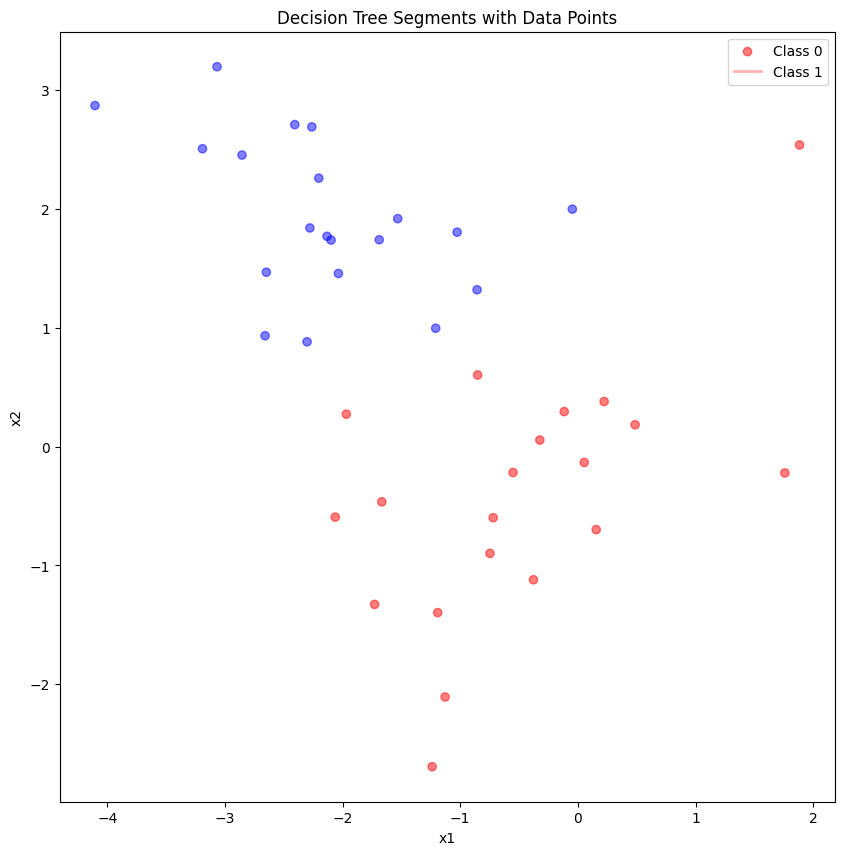

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, _tree
from scipy import stats

def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)  

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]] 
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]] 
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

df = generate_two_dimensional_data(20)

# Train the decision tree
X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Function to extract rectangles and labels from a trained decision tree
def get_rectangles_from_tree(tree):
    left = tree.children_left
    right = tree.children_right
    threshold = tree.threshold
    feature = tree.feature
    value = tree.value
    
    def recurse(node, bounds):
        if feature[node] == _tree.TREE_UNDEFINED:
            # It's a leaf node
            leaf_label = np.argmax(value[node][0])
            return [(bounds, leaf_label)]
        
        new_bounds_left = [list(b) for b in bounds]
        new_bounds_right = [list(b) for b in bounds]
        
        feature_index = feature[node]
        threshold_value = threshold[node]
        
        new_bounds_left[feature_index][1] = threshold_value
        new_bounds_right[feature_index][0] = threshold_value
        
        left_rectangles = recurse(left[node], new_bounds_left)
        right_rectangles = recurse(right[node], new_bounds_right)
        
        return left_rectangles + right_rectangles

    # Initialize bounds for each feature
    initial_bounds = [[-np.inf, np.inf] for _ in range(tree.n_features)]
    rectangles = recurse(0, initial_bounds)
    return rectangles

# Extract rectangles and labels from the decision tree
rectangles = get_rectangles_from_tree(clf.tree_)
print(rectangles)

# Calculate KDE for each class
class_0_data = df[df["Label"] == 0][X.columns]
class_1_data = df[df["Label"] == 1][X.columns]

kde_class_0 = stats.gaussian_kde(class_0_data.T)
kde_class_1 = stats.gaussian_kde(class_1_data.T)

# Calculate probabilities for the segments
segment_probabilities = []
for rect, label in rectangles:
    bounds_min = [b[0] for b in rect]
    bounds_max = [b[1] for b in rect]
    segment = df[np.all((df[X.columns] >= bounds_min) & (df[X.columns] < bounds_max), axis=1)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box(bounds_min, bounds_max))
        else:
            segment_probabilities.append(kde_class_0.integrate_box(bounds_min, bounds_max))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

# Plotting the data points and rectangles for 2D case
plt.figure(figsize=(10, 10))
colors = ['red' if label == 0 else 'blue' for label in df['Label']]
plt.scatter(df['x1'], df['x2'], c=colors, alpha=0.5, label='Data Points')

# Plot the rectangles
for rect, label in rectangles:
    (x1_start, x1_end), (x2_start, x2_end) = rect
    color = 'red' if label == 0 else 'blue'
    plt.plot([x1_start, x1_start, x1_end, x1_end, x1_start], 
             [x2_start, x2_end, x2_end, x2_start, x2_start], 
             color=color, alpha=0.3, lw=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Tree Segments with Data Points')
plt.legend(['Class 0', 'Class 1'])
plt.show()


Training Accuracy: 100.00%
[[-10.          -1.0081898  -10.           0.2875239    0.        ]
 [-10.          -1.0081898    0.2875239   10.           1.        ]
 [ -1.0081898   -0.35322063 -10.           0.4338218    0.        ]
 [ -1.0081898   -0.79411614   0.4338218    1.31542677   0.        ]
 [ -1.0081898   -0.79411614   1.31542677   1.52174395   1.        ]
 [ -0.79411614  -0.56181893   0.4338218    1.52174395   1.        ]
 [ -0.56181893  -0.40330502   0.4338218    0.53427494   1.        ]
 [ -0.56181893  -0.40330502   0.53427494   1.52174395   0.        ]
 [ -0.40330502  -0.35322063   0.4338218    1.52174395   1.        ]
 [ -1.0081898   -0.35322063   1.52174395  10.           1.        ]
 [ -0.35322063  -0.0342315  -10.          10.           0.        ]
 [ -0.0342315   -0.01094222 -10.          10.           1.        ]
 [ -0.01094222  10.         -10.          10.           0.        ]]
Total error probability across all segments: 0.1046
Accuracy: 0.8954


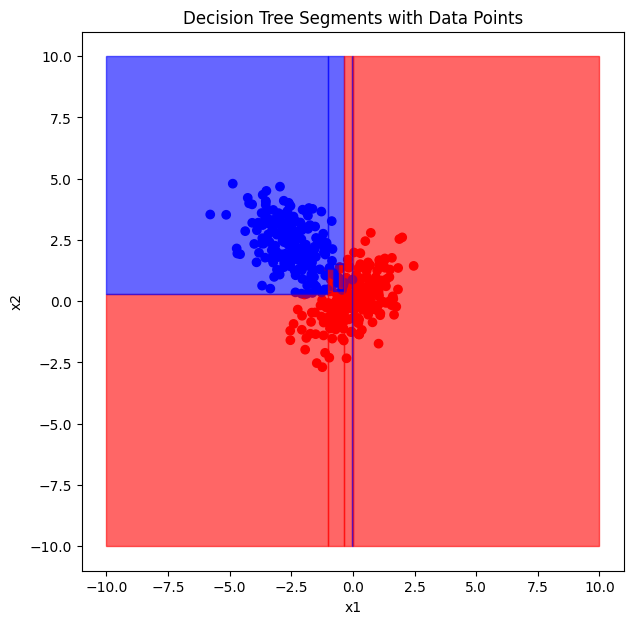

[Text(0.42857142857142855, 0.9444444444444444, 'x[0] <= -1.008\ngini = 0.5\nsamples = 400\nvalue = [200, 200]'),
 Text(0.21428571428571427, 0.8333333333333334, 'x[1] <= 0.288\ngini = 0.194\nsamples = 211\nvalue = [23, 188]'),
 Text(0.3214285714285714, 0.8888888888888888, 'True  '),
 Text(0.14285714285714285, 0.7222222222222222, 'gini = 0.0\nsamples = 23\nvalue = [23, 0]'),
 Text(0.2857142857142857, 0.7222222222222222, 'gini = 0.0\nsamples = 188\nvalue = [0, 188]'),
 Text(0.6428571428571429, 0.8333333333333334, 'x[0] <= -0.353\ngini = 0.119\nsamples = 189\nvalue = [177, 12]'),
 Text(0.5357142857142857, 0.8888888888888888, '  False'),
 Text(0.42857142857142855, 0.7222222222222222, 'x[1] <= 0.434\ngini = 0.311\nsamples = 57\nvalue = [46, 11]'),
 Text(0.35714285714285715, 0.6111111111111112, 'gini = 0.0\nsamples = 37\nvalue = [37, 0]'),
 Text(0.5, 0.6111111111111112, 'x[1] <= 1.522\ngini = 0.495\nsamples = 20\nvalue = [9, 11]'),
 Text(0.42857142857142855, 0.5, 'x[0] <= -0.403\ngini = 0.498

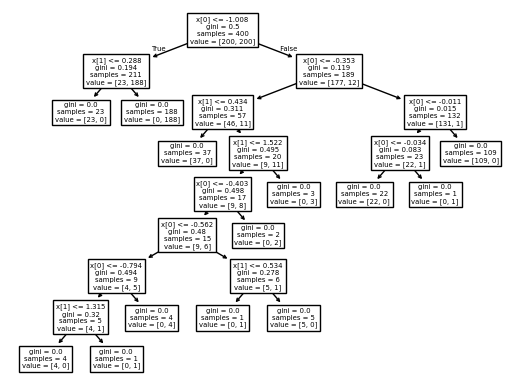

In [2]:
## Second mathod for calculation
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import deque
from sklearn.tree import _tree as ctree
from sklearn.tree import plot_tree
from scipy import stats
# Data generation function
def generate_two_dimensional_data(num_samples_per_class):
    np.random.seed(0)

    # Class 0
    mean_0 = [0, 0]
    cov_0 = [[1, 0.5], [0.5, 1]]
    class_0_data = np.random.multivariate_normal(mean_0, cov_0, num_samples_per_class)
    label_0 = np.zeros(num_samples_per_class)

    # Class 1
    mean_1 = [-2.5, 2.5]
    cov_1 = [[1, -0.5], [-0.5, 1]]
    class_1_data = np.random.multivariate_normal(mean_1, cov_1, num_samples_per_class)
    label_1 = np.ones(num_samples_per_class)

    # Concatenate data and labels
    data = np.vstack((class_0_data, class_1_data))
    labels = np.concatenate((label_0, label_1))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['x1', 'x2'])
    df['Label'] = labels

    return df

# Generate dataset
df = generate_two_dimensional_data(200)

X = df[['x1', 'x2']]
y = df['Label']

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf.fit(X, y)

training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# AABB and tree bounds classes/functions
class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right

def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i]) # 
            queue.extend([l, r])
    return aabbs

def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)
    

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    
    return rectangles
    

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['r', 'b'][int(rect[4])]
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.6)
        plt.gca().add_patch(rp)

# Extract decision areas
maxrange = [-10, 10, -10, 10]  # adjust based on your data range
rectangles = decision_areas(clf, maxrange)
print(rectangles)


class_0_data = df[df["Label"] == 0][['x1', 'x2']]
class_1_data = df[df["Label"] == 1][['x1', 'x2']]

kde_class_0 = stats.gaussian_kde(class_0_data.T)
kde_class_1 = stats.gaussian_kde(class_1_data.T)

# Calculate probabilities for the segments
segment_probabilities = []
for x1_start, x1_end, x2_start, x2_end, label in rectangles:
    segment = df[(df['x1'] >= x1_start) & (df['x1'] < x1_end) & (df['x2'] >= x2_start) & (df['x2'] < x2_end)]
    if not segment.empty:
        actual_value = segment["Label"].iloc[0]
        if actual_value == 0.0:
            segment_probabilities.append(kde_class_1.integrate_box([x1_start, x2_start], [x1_end, x2_end]))
        else:
            segment_probabilities.append(kde_class_0.integrate_box([x1_start, x2_start], [x1_end, x2_end]))

# Compute total error probability
total_error_probability_all_segments = np.sum(segment_probabilities)

print(f"Total error probability across all segments: {total_error_probability_all_segments:.4f}")
print(f"Accuracy: {1 - total_error_probability_all_segments:.4f}")

# Plot the data points and decision areas
plt.figure(figsize=(7, 7))
colors = ['red' if label == 0 else 'blue' for label in df['Label']]
plt.scatter(df['x1'], df['x2'], c=colors, label='Data Points')

# Plot the decision areas
plot_areas(rectangles)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision Tree Segments with Data Points')
# plt.legend(['Class 0', 'Class 1'])
plt.show()

plot_tree(clf)


In [84]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# X = df[['feature']]
# y = df['Label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X, y)
    y_pred = model.predict(X)
    # global performance
    global_accuracy = accuracy_score(y, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")

Model name: logistic_regression, global_accuracy: 1.0, Scores for each fold: [1.    1.    0.875 1.    0.875], Average_score: 0.95
Model name: naive_bayes, global_accuracy: 1.0, Scores for each fold: [1.    1.    1.    0.875 0.875], Average_score: 0.95
Model name: random_forest, global_accuracy: 0.975, Scores for each fold: [1.    1.    1.    1.    0.875], Average_score: 0.975


## Continuous case (Ambiguity Calculation)

For continuous case ambiguty calculation we are calculating the overlap region beteween the hypercube of feature space of different classes.

$\large mean(\frac{A_{inter1}}{A_{class1}}, \frac{A_{inter2}}{A_{class2}}....) $.

$A_{inter1}$ is the number of samples of class 1 in the common region and $A_{class1}$ is the number of total samples that belongs to class 1.

In [14]:
import pandas as pd
import numpy as np

def calculate_hypercubes(df, class_column):
    features = df.columns.drop(class_column)
    classes = df[class_column].unique()

    grouped = df.groupby(class_column)[features]
    min_values = grouped.min()
    max_values = grouped.max()

    hypercubes = {cls: (min_values.loc[cls].values, max_values.loc[cls].values) for cls in classes}
    
    return hypercubes

def calculate_overlap_regions(hypercubes):
    classes = list(hypercubes.keys())
    num_classes = len(classes)
    
    overlap_regions = []
    
    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            min_overlap = np.maximum(hypercubes[classes[i]][0], hypercubes[classes[j]][0])
            max_overlap = np.minimum(hypercubes[classes[i]][1], hypercubes[classes[j]][1])
            if np.all(min_overlap <= max_overlap):
                overlap_regions.append((classes[i], classes[j], min_overlap, max_overlap))
    
    return overlap_regions

def count_samples_in_overlap_regions(df, class_column, overlap_regions):
    features = df.columns.drop(class_column)
    samples = df[features].values
    class_labels = df[class_column].values
    classes = df[class_column].unique()

    samples_in_overlap = {}

    for cls1, cls2, min_overlap, max_overlap in overlap_regions:
        in_overlap_cls1 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls1)
        in_overlap_cls2 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls2)

        count_cls1 = np.sum(in_overlap_cls1)
        count_cls2 = np.sum(in_overlap_cls2)

        region_key = f'{cls1}-{cls2}'
        samples_in_overlap[region_key] = {cls1: count_cls1, cls2: count_cls2}
    
    return samples_in_overlap

def calculate_ambiguity(samples_in_overlap, df, class_column):
    total_samples_per_class = df[class_column].value_counts().to_dict()
    ambiguity_values = []

    for region, counts in samples_in_overlap.items():
        cls1, cls2 = map(int, region.split('-'))
        if cls1 in total_samples_per_class and cls2 in total_samples_per_class:
            ambiguity_cls1 = counts[cls1] / total_samples_per_class[cls1]
            ambiguity_cls2 = counts[cls2] / total_samples_per_class[cls2]
            ambiguity_values.extend([ambiguity_cls1, ambiguity_cls2])

    mean_ambiguity = np.mean(ambiguity_values) if ambiguity_values else 0.0
    return mean_ambiguity

# Example usage
data3 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'feature2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6],
    'feature2': [5, 6, 7, 8, 9, 10],
    'class': [0, 0, 1, 1, 0, 1]
})

data2 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

hypercubes = calculate_hypercubes(data, 'class')
print("Hypercubes for each class:")
for cls, (min_vals, max_vals) in hypercubes.items():
    print(f"Class {cls}: Min values {min_vals}, Max values {max_vals}")

overlap_regions = calculate_overlap_regions(hypercubes)
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

samples_in_overlap = count_samples_in_overlap_regions(data, 'class', overlap_regions)
print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")

mean_ambiguity = calculate_ambiguity(samples_in_overlap, data, 'class')
print(f'Continuous Case Ambiguity: {mean_ambiguity}')


Hypercubes for each class:
Class 0: Min values [1 5], Max values [5 9]
Class 1: Min values [3 7], Max values [ 6 10]
Overlap regions between classes:
Classes 0 and 1: Min overlap [3 7], Max overlap [5 9]
Samples in Overlap Regions:
Overlap region 0-1: {0: 1, 1: 2}
Continuous Case Ambiguity: 0.5


# Discrete classification case

In [15]:
import pandas as pd

data = {
    "x1": [0, 0, 1, 1, 0, 0, 1],
    "x2": [0, 1, 0, 1, 0, 0, 0],
    "L": [0, 1, 1, 0, 1, 0, 0]
}
df1 = pd.DataFrame(data)


def majority_vote(df, feature_columns, class_column):
    # combinaion generators
    df["feature_combination"] = df[feature_columns].astype(str).agg('_'.join, axis=1)
    
    # total no of combinations
    combination_counts = df.groupby(['feature_combination', class_column]).size().reset_index(name='count')
    
    # no of combination
    total_combination_counts = df['feature_combination'].value_counts().reset_index(name='total_count').rename(columns={'index': 'feature_combination'})
    
    combination_probs = pd.merge(combination_counts, total_combination_counts, on='feature_combination')
    combination_probs['probability'] = combination_probs['count'] / combination_probs['total_count']
    
    
    combination_probs_pivot = combination_probs.pivot(index='feature_combination', columns=class_column, values='probability').fillna(0)
    combination_probs_pivot.columns = [f'P(class={int(col)})' for col in combination_probs_pivot.columns]
    
    df = pd.merge(df, combination_probs, on=['feature_combination', class_column], how='left')
    
    return df, combination_probs_pivot



df, combination_pivot = majority_vote(df1, feature_columns=["x1", "x2"], class_column="L")

# print(df)
print(combination_pivot)


                     P(class=0)  P(class=1)
feature_combination                        
0_0                    0.666667    0.333333
0_1                    0.000000    1.000000
1_0                    0.500000    0.500000
1_1                    1.000000    0.000000


In [19]:
### Categorical dataset
import pandas as pd
import numpy as np

def generate_dummy_categorical_classification_dataset(num_rows=100):
    # Define categories
    genders = ['Male', 'Female', 'Other']
    marital_statuses = ['Single', 'Married', 'Divorced', 'Widowed']
    blood_types = ['A', 'B', 'AB', 'O']
    # payment_methods = ['Cash', 'Credit Card', 'Online Transfer']
    
    # Generate random data
    data = {
        'Gender': np.random.choice(genders, num_rows),
        'Marital Status': np.random.choice(marital_statuses, num_rows),
        'Blood Type': np.random.choice(blood_types, num_rows),
        # 'Payment Method': np.random.choice(payment_methods, num_rows),
        'Label': np.random.choice((0,1), num_rows)
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df

# Example usage
dummy_classification_df = generate_dummy_categorical_classification_dataset(100)
 
df, combination_pivot = majority_vote(dummy_classification_df, feature_columns=["Gender", "Marital Status", "Blood Type"], class_column="Label")
# print(df)
# print(combination_pivot)
class_total=dummy_classification_df.groupby(["Label"]).count()
class_total
dummy_classification_df.groupby(["Gender", "Marital Status", "Blood Type", "Label"]).count().unstack(3)#/class_total.values[:, 0]


       Gender  Marital Status  Blood Type  feature_combination
Label                                                         
0          47              47          47                   47
1          53              53          53                   53
[47 53]


In [56]:
# dummy_classification_df["Blood Type"] = dummy_classification_df["Blood Type"].astype("category")
probs = (dummy_classification_df.groupby(["Gender", "Marital Status", "Blood Type", "Label"]).count().unstack(3)/class_total.values[:, 0])
probs

feature_combination          
Label                                              0         1
Gender Marital Status Blood Type                              
Female Divorced       A                     0.042553  0.037736
                      AB                    0.042553  0.037736
                      B                          NaN  0.075472
                      O                     0.042553  0.075472
       Married        A                          NaN  0.018868
                      AB                         NaN  0.037736
                      B                     0.021277       NaN
                      O                     0.021277       NaN
       Single         A                          NaN  0.018868
                      B                     0.042553       NaN
                      O                     0.021277  0.037736
       Widowed        A                     0.042553  0.037736
                      AB                    0.021277  0.018868
Male   Divorced       A                     0.021277  0.056604
                      AB                    0.042553  0.037736
                      B                     0.042553  0.018868
                      O                     0.021277       NaN
       Married        AB                    0.021277  0.018868
                      B                     0.021277       NaN
                      O                          NaN  0.018868
       Single         A                          NaN  0.037736
                      AB                    0.021277  0.018868
                      B                     0.042553  0.018868
       Widowed        A                     0.042553  0.018868
                      AB                    0.042553  0.037736
                      B                     0.042553  0.018868
                      O                     0.021277  0.037736
Other  Divorced       A                     0.021277  0.018868
                      AB                    0.021277  0.037736
                      B                     0.021277  0.037736
                      O                          NaN  0.037736
       Married        A                     0.021277       NaN
                      B                     0.021277       NaN
                      O                     0.042553  0.018868
       Single         A                          NaN  0.037736
                      AB                    0.042553       NaN
                      B                          NaN  0.018868
                      O                     0.021277  0.018868
       Widowed        A                     0.063830       NaN
                      B                          NaN  0.018868
                      O                     0.042553  0.018868

In [57]:
(probs.values > 0)[:,::-1]

array([[ True,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True,  True],
       [False,  True],
       [ True, False],
       [ True,  True]])

In [ ]:
(probs * (probs.values > 0)[:,::-1]).sum()

In [59]:
counts = (dummy_classification_df.groupby(["Gender", "Marital Status", "Blood Type", "Label"]).count().unstack(3))
((counts / counts.sum(axis=1).values.reshape(-1,1)).fillna(0).min(axis=1) / 0.5).mean()


0.4349593495934959

In [60]:
counts

feature_combination     
Label                                              0    1
Gender Marital Status Blood Type                         
Female Divorced       A                          2.0  2.0
                      AB                         2.0  2.0
                      B                          NaN  4.0
                      O                          2.0  4.0
       Married        A                          NaN  1.0
                      AB                         NaN  2.0
                      B                          1.0  NaN
                      O                          1.0  NaN
       Single         A                          NaN  1.0
                      B                          2.0  NaN
                      O                          1.0  2.0
       Widowed        A                          2.0  2.0
                      AB                         1.0  1.0
Male   Divorced       A                          1.0  3.0
                      AB                         2.0  2.0
                      B                          2.0  1.0
                      O                          1.0  NaN
       Married        AB                         1.0  1.0
                      B                          1.0  NaN
                      O                          NaN  1.0
       Single         A                          NaN  2.0
                      AB                         1.0  1.0
                      B                          2.0  1.0
       Widowed        A                          2.0  1.0
                      AB                         2.0  2.0
                      B                          2.0  1.0
                      O                          1.0  2.0
Other  Divorced       A                          1.0  1.0
                      AB                         1.0  2.0
                      B                          1.0  2.0
                      O                          NaN  2.0
       Married        A                          1.0  NaN
                      B                          1.0  NaN
                      O                          2.0  1.0
       Single         A                          NaN  2.0
                      AB                         2.0  NaN
                      B                          NaN  1.0
                      O                          1.0  1.0
       Widowed        A                          3.0  NaN
                      B                          NaN  1.0
                      O                          2.0  1.0

In [61]:
import pandas as pd
import numpy as np

df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\milknew.csv")
df.head()

<>:4: SyntaxWarning: invalid escape sequence '\F'
<>:4: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shibl\AppData\Local\Temp\ipykernel_20288\166459386.py:4: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\milknew.csv")


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [64]:
df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\cancer_patient_data_sets.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shibl\AppData\Local\Temp\ipykernel_20288\433459415.py:1: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\cancer_patient_data_sets.csv")


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High
